## Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import sys
import json

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

# custom helper functions
from utils import *

RANDOM_SEED = 0

2022-05-02 21:14:24.060231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 21:14:24.060274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load Data & Develop Test/Train Splits

In [2]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan.json"
MULTIMODAL_PATH = "/storage/graham/music/fma_small_echonest.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [3]:
%%time
genres, mfcc, features, y = load_multimodal_data(MULTIMODAL_PATH)

CPU times: user 25.8 s, sys: 3.91 s, total: 29.7 s
Wall time: 30.4 s


### Prepare Dataset

In [4]:
TEST_SPLIT = 0.3
VALIDATION_SPLIT = 0.3

# create train/test/val splits
x_train, x_val, x_test, y_train, y_val, y_test = test_train_val_split(features, 
                                                                      y, 
                                                                      test_size=TEST_SPLIT, 
                                                                      val_size=VALIDATION_SPLIT, 
                                                                      rseed=RANDOM_SEED)

mfcc_train, mfcc_val, mfcc_test, _, _, _ = test_train_val_split(mfcc, 
                                                                  y, 
                                                                  test_size=TEST_SPLIT, 
                                                                  val_size=VALIDATION_SPLIT, 
                                                                  rseed=RANDOM_SEED)

# reshape MFCC to be a vector
mfcc_train_vec = mfcc_train.reshape(mfcc_train.shape[0], mfcc_train.shape[1]*mfcc_train.shape[2])
mfcc_test_vec = mfcc_test.reshape(mfcc_test.shape[0], mfcc_test.shape[1]*mfcc_test.shape[2])

mfcc_vec = mfcc.reshape(mfcc.shape[0], mfcc.shape[1]*mfcc.shape[2])

# add an axis to input sets
mfcc_train_cnn = mfcc_train[..., np.newaxis]
mfcc_val_cnn = mfcc_val[..., np.newaxis]
mfcc_test_cnn = mfcc_test[..., np.newaxis]

cnn_input_shape = (mfcc_train.shape[1], mfcc_train.shape[2], 1)
mlp_input_shape = x_train.shape[1]

## EDA: t-SNE of Echonest Data

In [5]:
%%time
echonest_tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
echonest_tsne_results = echonest_tsne.fit_transform(features)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:94: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:110: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 12227 samples in 0.069s...
[t-SNE] Computed neighbors for 12227 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12227
[t-SNE] Computed conditional probabilities for sample 2000 / 12227
[t-SNE] Computed conditional probabilities for sample 3000 / 12227
[t-SNE] Computed conditional probabilities for sample 4000 / 12227
[t-SNE] Computed conditional probabilities for sample 5000 / 12227
[t-SNE] Computed conditional probabilities for sample 6000 / 12227
[t-SNE] Computed conditional probabilities for sample 7000 / 12227
[t-SNE] Computed conditional probabilities for sample 8000 / 12227
[t-SNE] Computed conditional probabilities for sample 9000 / 12227
[t-SNE] Computed conditional probabilities for sample 10000 / 12227
[t-SNE] Computed conditional probabilities for sample 11000 / 12227
[t-SNE] Computed conditional probabilities for sample 12000 / 12227
[t-SNE] Computed conditional probabilities for sam

<Figure size 1728x1296 with 0 Axes>

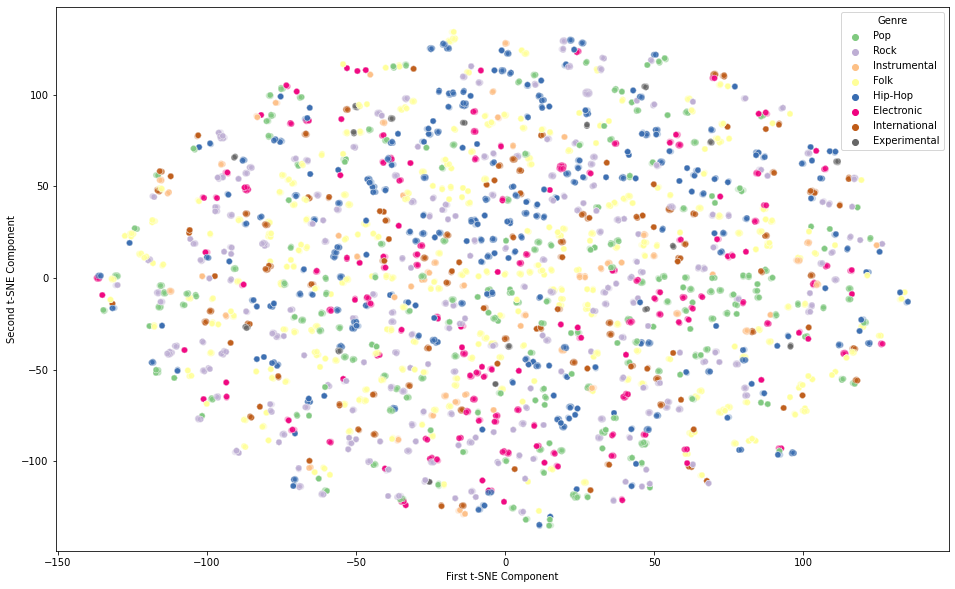

In [6]:
df_echonest = pd.DataFrame()
df_echonest['tsne-1'] = echonest_tsne_results[:,0]
df_echonest['tsne-2'] = echonest_tsne_results[:,1]

# apply labels
labs = [genres[x] for x in y]
df_echonest['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-1', 
                y='tsne-2',
                hue='Genre',
                palette=sns.color_palette('Accent', len(genres)), 
                data=df_echonest, 
                legend='full', 
                alpha=0.3
)
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.show()

## EDA: First Two Principle Components

<Figure size 1728x1296 with 0 Axes>

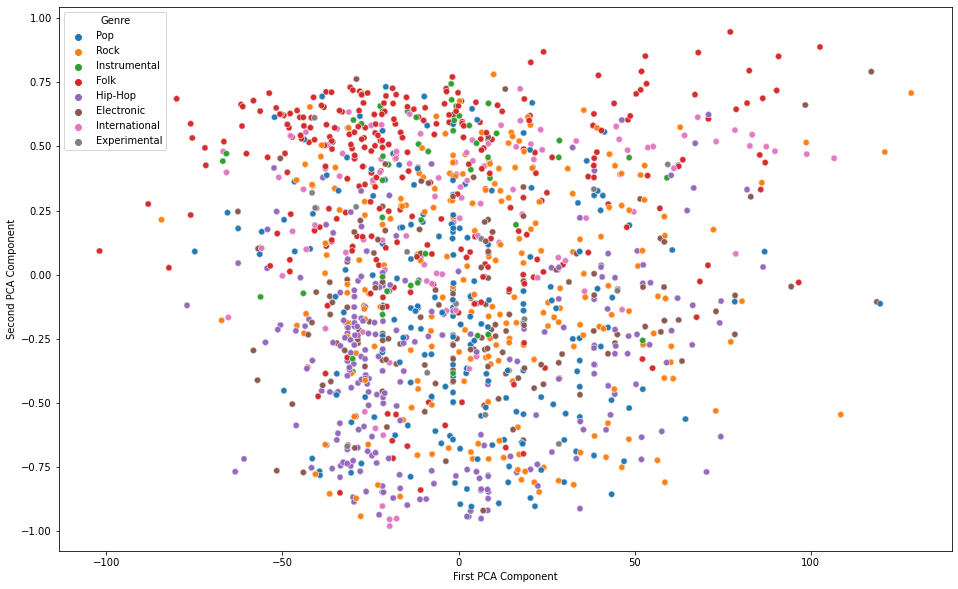

In [7]:
pca = PCA()
pca.n_components = 2
pca_data = pca.fit_transform(features)

pca_echonest = pd.DataFrame()
pca_echonest['pca-1'] = pca_data[:,0]
pca_echonest['pca-2'] = pca_data[:,1]

# apply labels
labs = [genres[x] for x in y]
pca_echonest['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='pca-1', 
                y='pca-2',
                hue='Genre',
                palette=sns.color_palette('tab10', len(genres)), 
                data=pca_echonest, 
                legend='full', 
                alpha=0.3
)
plt.xlabel("First PCA Component")
plt.ylabel("Second PCA Component")
plt.show()

## t-SNE of MFCC Data

In [8]:
%%time
echonest_tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000)
echonest_tsne_results = echonest_tsne.fit_transform(mfcc_vec)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:94: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:110: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 12227 samples in 0.119s...
[t-SNE] Computed neighbors for 12227 samples in 1.481s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12227
[t-SNE] Computed conditional probabilities for sample 2000 / 12227
[t-SNE] Computed conditional probabilities for sample 3000 / 12227
[t-SNE] Computed conditional probabilities for sample 4000 / 12227
[t-SNE] Computed conditional probabilities for sample 5000 / 12227
[t-SNE] Computed conditional probabilities for sample 6000 / 12227
[t-SNE] Computed conditional probabilities for sample 7000 / 12227
[t-SNE] Computed conditional probabilities for sample 8000 / 12227
[t-SNE] Computed conditional probabilities for sample 9000 / 12227
[t-SNE] Computed conditional probabilities for sample 10000 / 12227
[t-SNE] Computed conditional probabilities for sample 11000 / 12227
[t-SNE] Computed conditional probabilities for sample 12000 / 12227
[t-SNE] Computed conditional probabilities for sam

<Figure size 1728x1296 with 0 Axes>

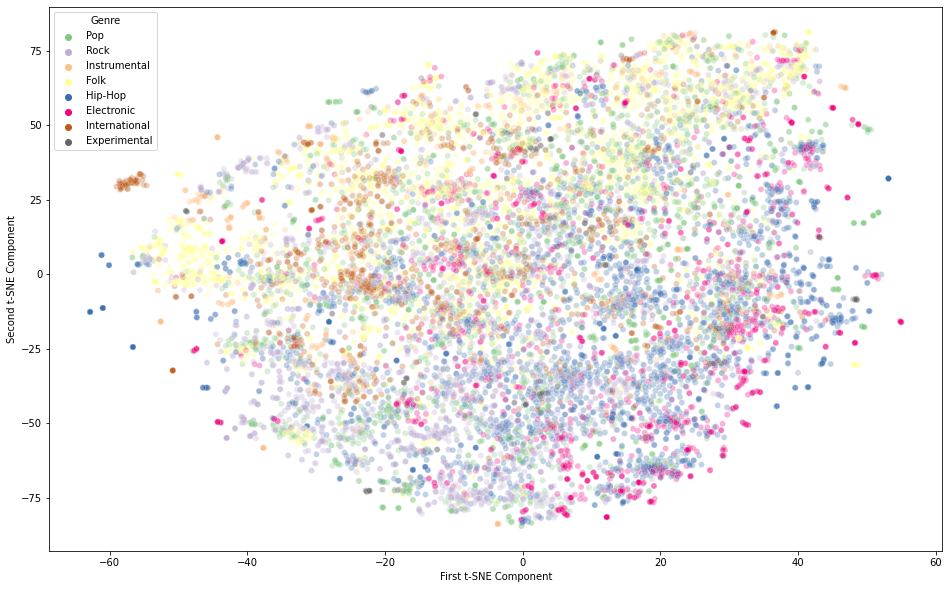

In [9]:
df_echonest = pd.DataFrame()
df_echonest['tsne-1'] = echonest_tsne_results[:,0]
df_echonest['tsne-2'] = echonest_tsne_results[:,1]

# apply labels
labs = [genres[x] for x in y]
df_echonest['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-1', 
                y='tsne-2',
                hue='Genre',
                palette=sns.color_palette('Accent', len(genres)), 
                data=df_echonest, 
                legend='full', 
                alpha=0.3
)
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.show()

## Train Classical Models: MFCC

### K-Nearest Neighbors Classifier

In [10]:
%%time
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(mfcc_train_vec, y_train)
y_pred_knn = KNNmodel.predict(mfcc_test_vec)

print_report(y_test, y_pred_knn)

Accuracy Score is:	 0.439
              precision    recall  f1-score   support

           0       0.38      0.47      0.42       418
           1       0.50      0.17      0.25        60
           2       0.47      0.77      0.59       844
           3       0.84      0.14      0.25       681
           4       0.45      0.26      0.33       140
           5       0.65      0.13      0.22       277
           6       0.53      0.16      0.24       561
           7       0.37      0.71      0.48       688

    accuracy                           0.44      3669
   macro avg       0.52      0.35      0.35      3669
weighted avg       0.53      0.44      0.39      3669

[[197   0  85   8   4   2  17 105]
 [  8  10  22   3   1   0   0  16]
 [ 43   1 653   1   7   7  10 122]
 [128   5 109  98   0   8  26 307]
 [  3   0  59   0  37   2   4  35]
 [ 29   3  98   1  13  37   3  93]
 [ 66   1 229   3   9   1  88 164]
 [ 38   0 129   2  11   0  19 489]]
CPU times: user 16.6 s, sys: 853 ms, total

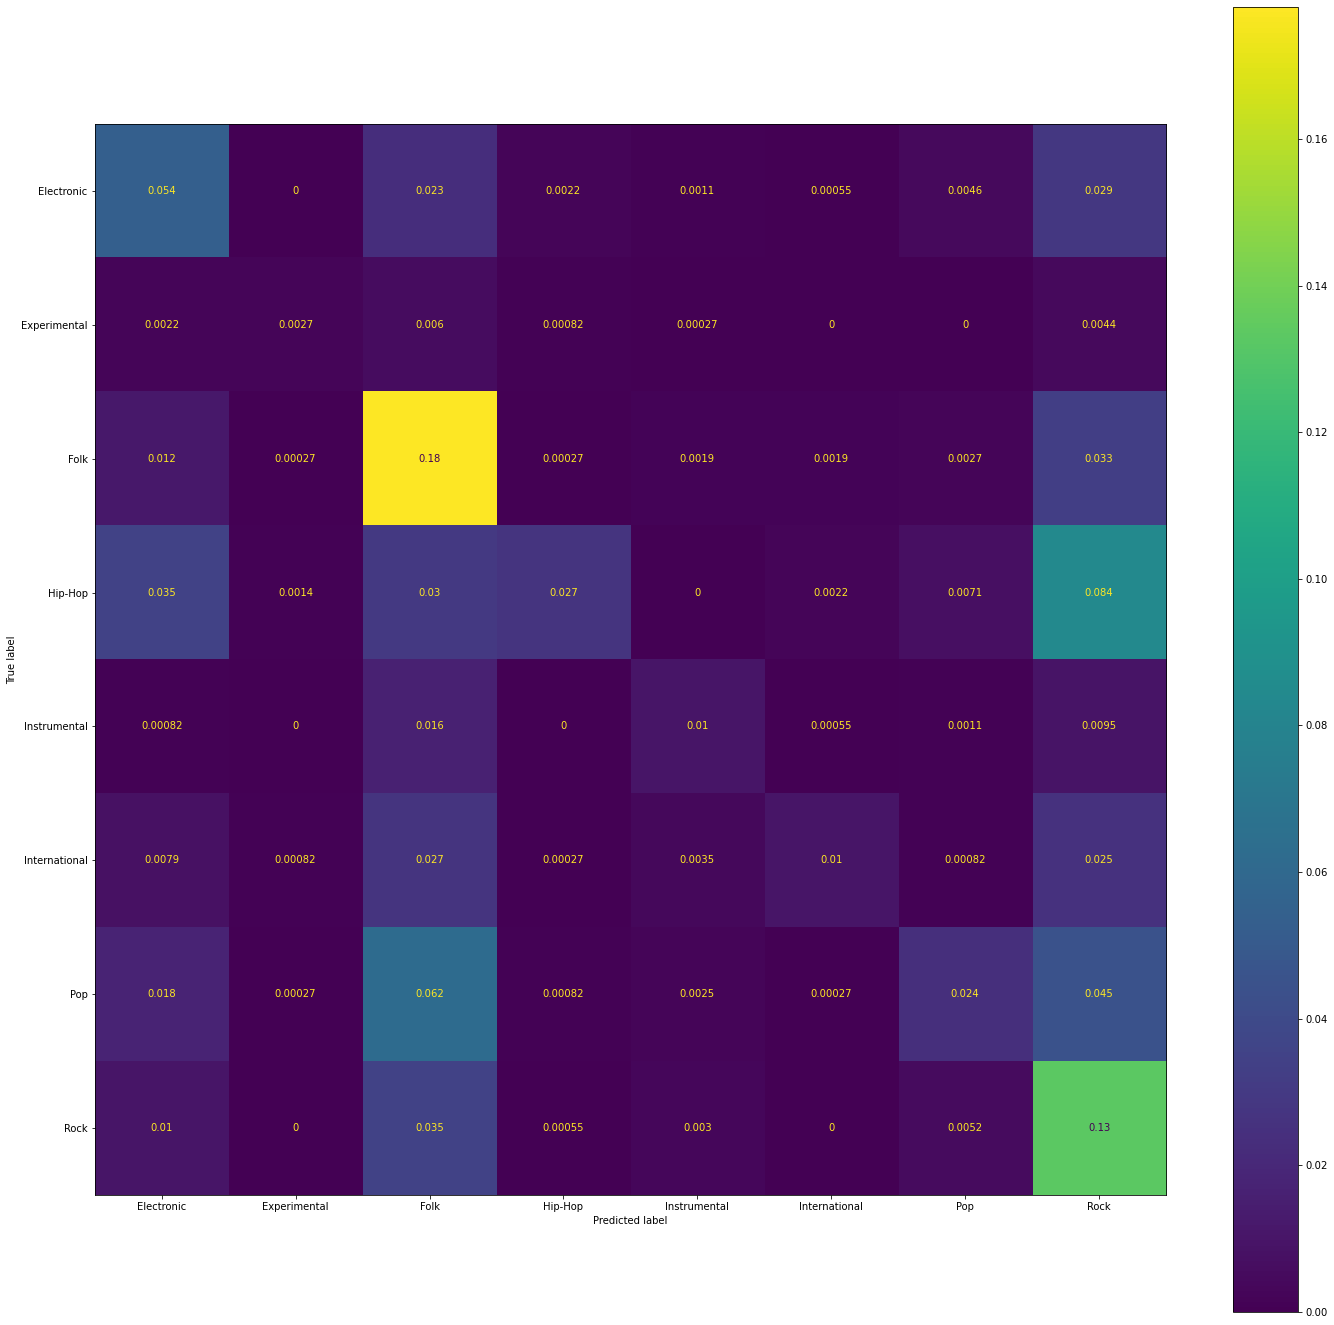

In [11]:
cm = confusion_matrix(y_test, y_pred_knn, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Support Vector Machine Classifier

In [12]:
%%time
SVMmodel = SVC()
SVMmodel.fit(mfcc_train_vec, y_train)
y_pred_svm =  SVMmodel.predict(mfcc_test_vec)

print_report(y_test, y_pred_svm)

Accuracy Score is:	 0.494
              precision    recall  f1-score   support

           0       0.52      0.19      0.28       418
           1       0.00      0.00      0.00        60
           2       0.49      0.85      0.63       844
           3       0.48      0.71      0.58       681
           4       0.00      0.00      0.00       140
           5       0.49      0.13      0.21       277
           6       0.42      0.18      0.25       561
           7       0.53      0.58      0.55       688

    accuracy                           0.49      3669
   macro avg       0.37      0.33      0.31      3669
weighted avg       0.46      0.49      0.44      3669

[[ 78   0  75 197   0   2  28  38]
 [  0   0  27  12   0   1   7  13]
 [  1   0 717  40   0   9  30  47]
 [ 31   0  43 484   0   7  27  89]
 [  2   0  86  13   0  11  10  18]
 [  0   0 148  48   0  37  15  29]
 [ 20   0 196 116   0   6 101 122]
 [ 17   0 157  89   2   3  23 397]]
CPU times: user 1min 38s, sys: 17.7 s, tot

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

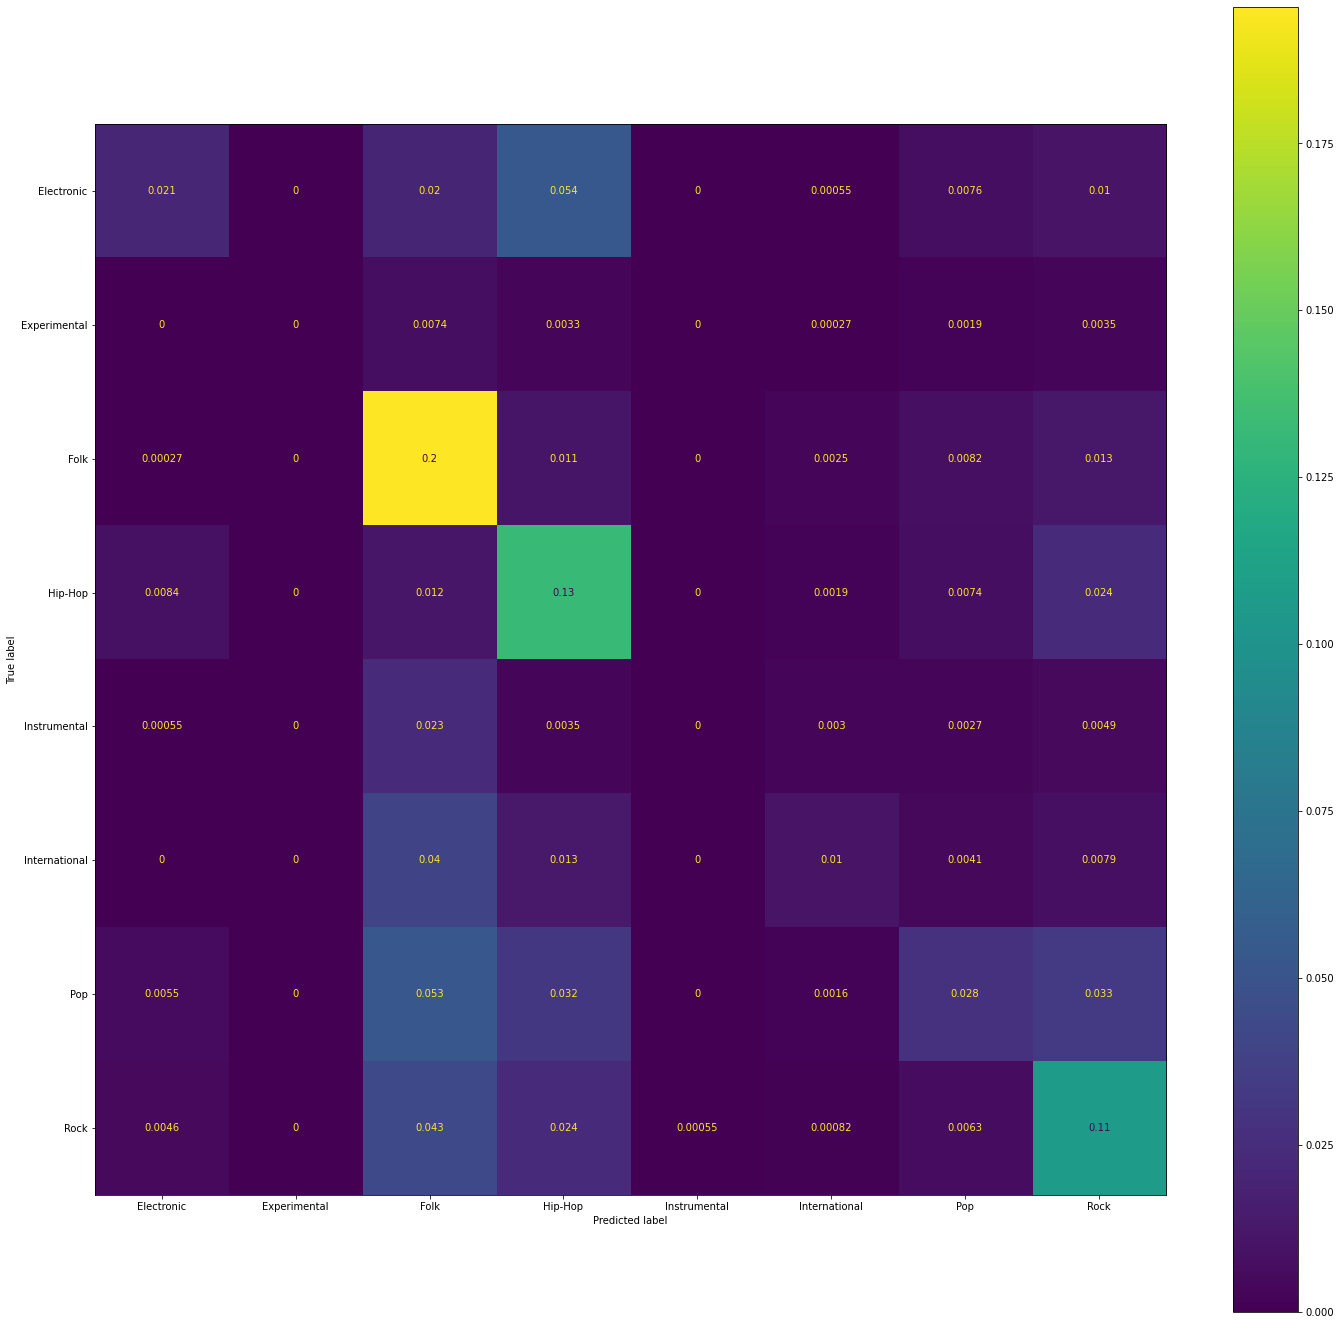

In [13]:
cm = confusion_matrix(y_test, y_pred_svm, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Random Forest Classifier

In [14]:
%%time

RFmodel = RandomForestClassifier()
RFmodel.fit(mfcc_train_vec, y_train)

y_pred_rf =  RFmodel.predict(mfcc_test_vec)
print_report(y_test, y_pred_rf)

Accuracy Score is:	 0.527
              precision    recall  f1-score   support

           0       0.63      0.33      0.44       418
           1       1.00      0.13      0.24        60
           2       0.53      0.83      0.65       844
           3       0.49      0.72      0.58       681
           4       0.82      0.10      0.18       140
           5       0.47      0.19      0.28       277
           6       0.39      0.23      0.29       561
           7       0.59      0.58      0.58       688

    accuracy                           0.53      3669
   macro avg       0.62      0.39      0.40      3669
weighted avg       0.54      0.53      0.49      3669

[[139   0  67 149   1   4  33  25]
 [  4   8  26   9   0   2   5   6]
 [  7   0 704  39   1  14  34  45]
 [ 30   0  43 487   0   8  47  66]
 [  4   0  72  14  14   8   8  20]
 [  2   0 123  46   0  54  34  18]
 [ 14   0 177 136   0  13 131  90]
 [ 20   0 110 107   1  11  43 396]]
CPU times: user 9min 5s, sys: 798 ms, tota

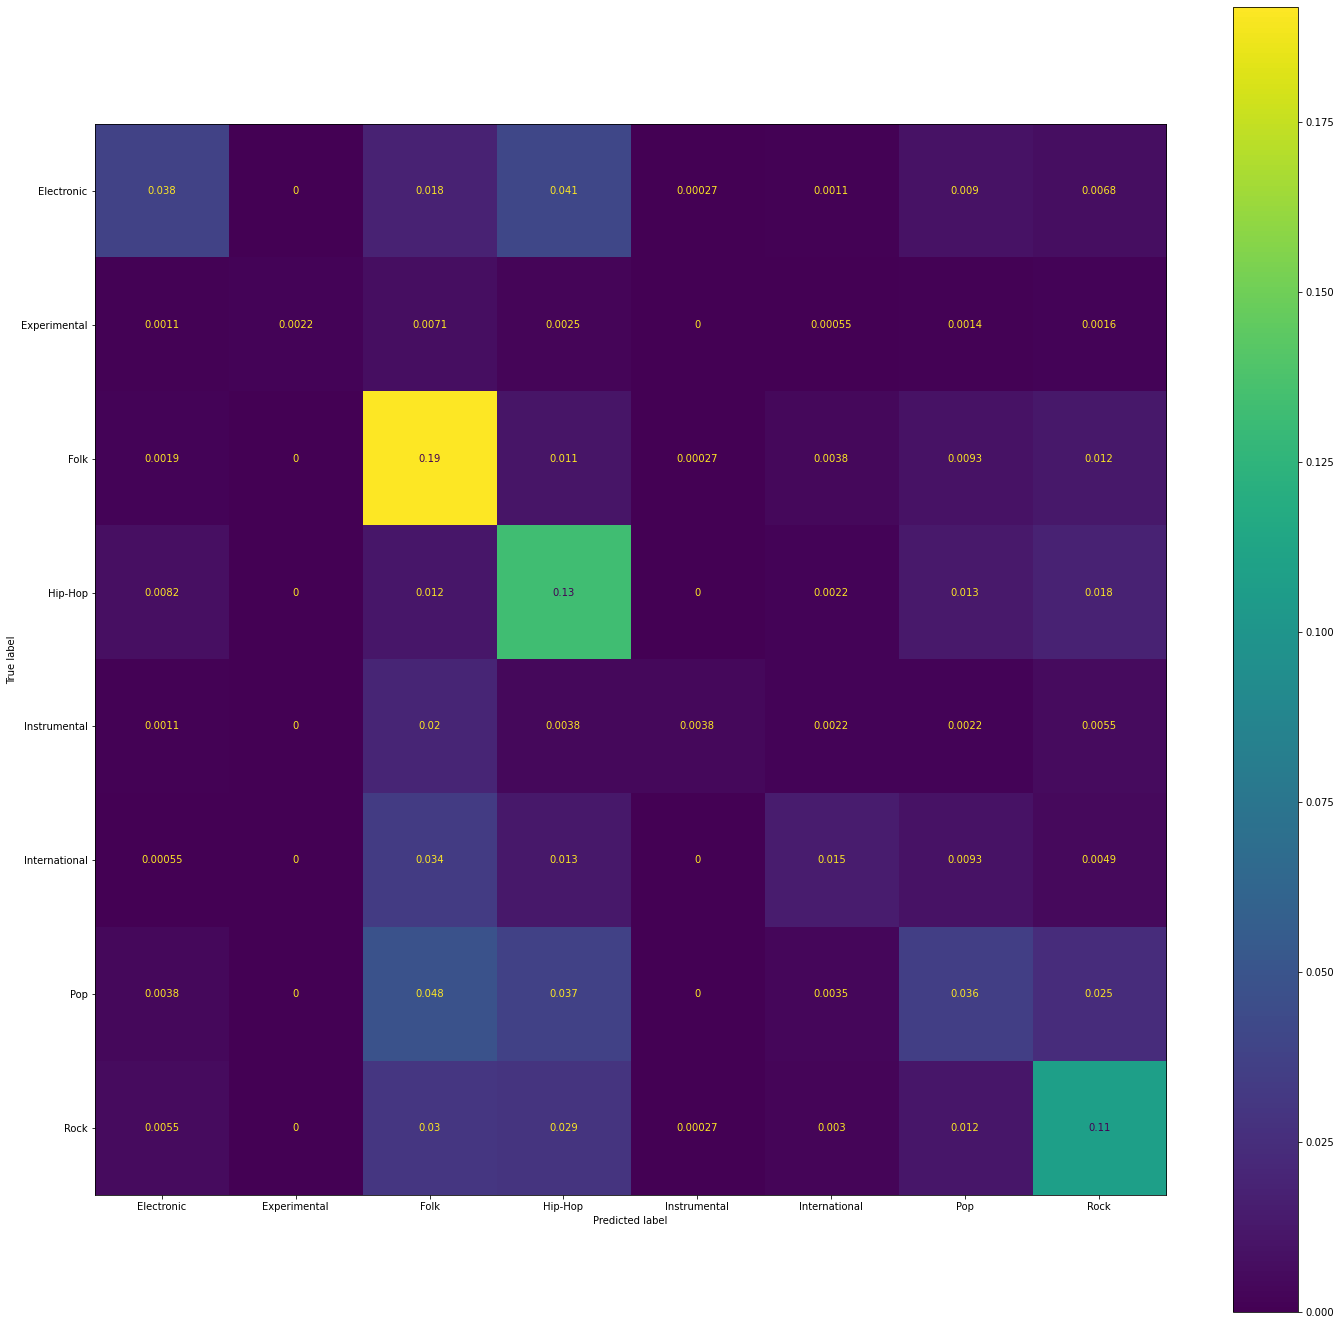

In [15]:
cm = confusion_matrix(y_test, y_pred_rf, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Gradient Boosted Classifier

In [16]:
%%time

XGBmodel = XGBClassifier()
XGBmodel.fit(mfcc_train_vec, y_train)

y_pred_xgb =  XGBmodel.predict(mfcc_test_vec)
print_report(y_test, y_pred_xgb)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score is:	 0.561
              precision    recall  f1-score   support

           0       0.61      0.41      0.49       418
           1       0.75      0.15      0.25        60
           2       0.59      0.79      0.68       844
           3       0.57      0.66      0.61       681
           4       0.79      0.21      0.34       140
           5       0.49      0.39      0.43       277
           6       0.41      0.35      0.37       561
           7       0.58      0.63      0.61       688

    accuracy                           0.56      3669
   macro avg       0.60      0.45      0.47      3669
weighted avg       0.56      0.56      0.55      3669

[[170   0  47 122   0  14  35  30]
 [  6   9  19  11   0   7   3   5]


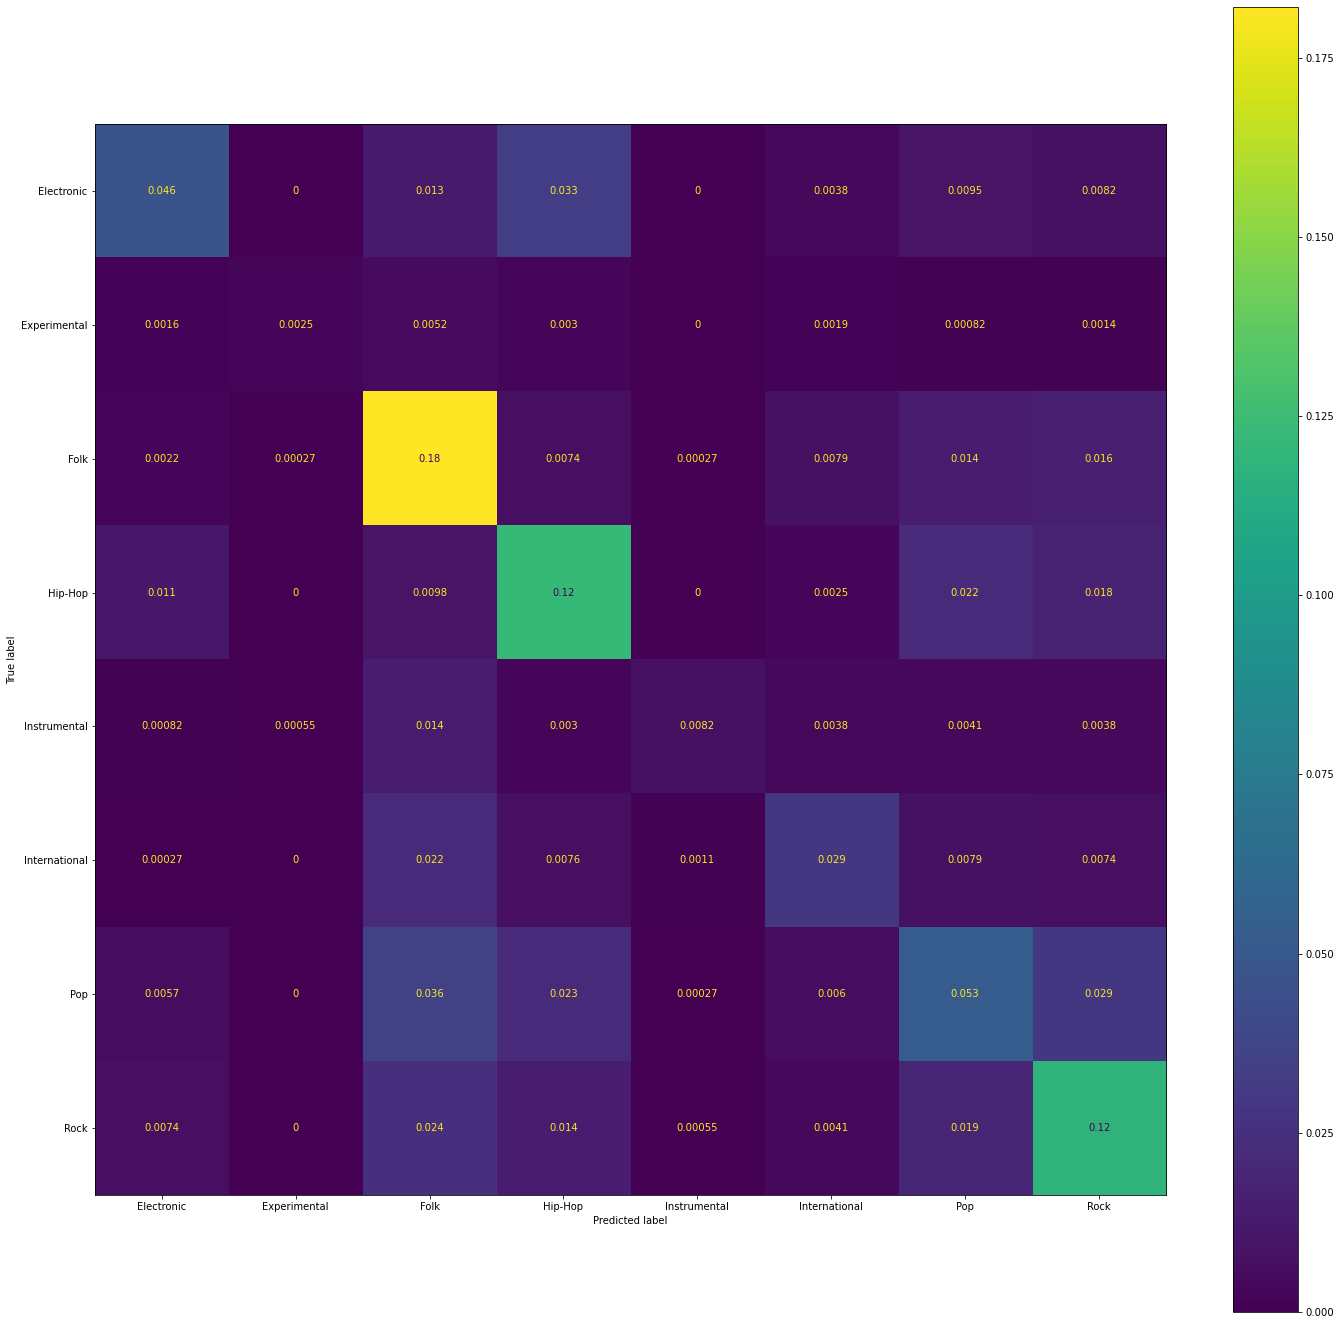

In [17]:
cm = confusion_matrix(y_test, y_pred_xgb, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

## Train Classical Models: Echonest Features

### K-Nearest Neighbors Classifier

In [18]:
%%time
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(x_train, y_train)
y_pred_knn = KNNmodel.predict(x_test)

print_report(y_test, y_pred_knn)

Accuracy Score is:	 0.654
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       418
           1       0.45      0.42      0.43        60
           2       0.67      0.84      0.75       844
           3       0.72      0.72      0.72       681
           4       0.50      0.46      0.48       140
           5       0.62      0.53      0.57       277
           6       0.63      0.60      0.62       561
           7       0.71      0.54      0.61       688

    accuracy                           0.65      3669
   macro avg       0.61      0.59      0.60      3669
weighted avg       0.65      0.65      0.65      3669

[[257   0  28  38  16   0  40  39]
 [  3  25  15   7   0  10   0   0]
 [ 27  11 708  21  13  20  30  14]
 [ 41   7  66 487   5  13  37  25]
 [  5   3  27  22  65   0   7  11]
 [ 22   3  52  13  14 148  12  13]
 [ 46   3  53  38  13  18 339  51]
 [ 53   3 107  53   4  30  69 369]]
CPU times: user 1.09 s, sys: 50.8 ms, tota

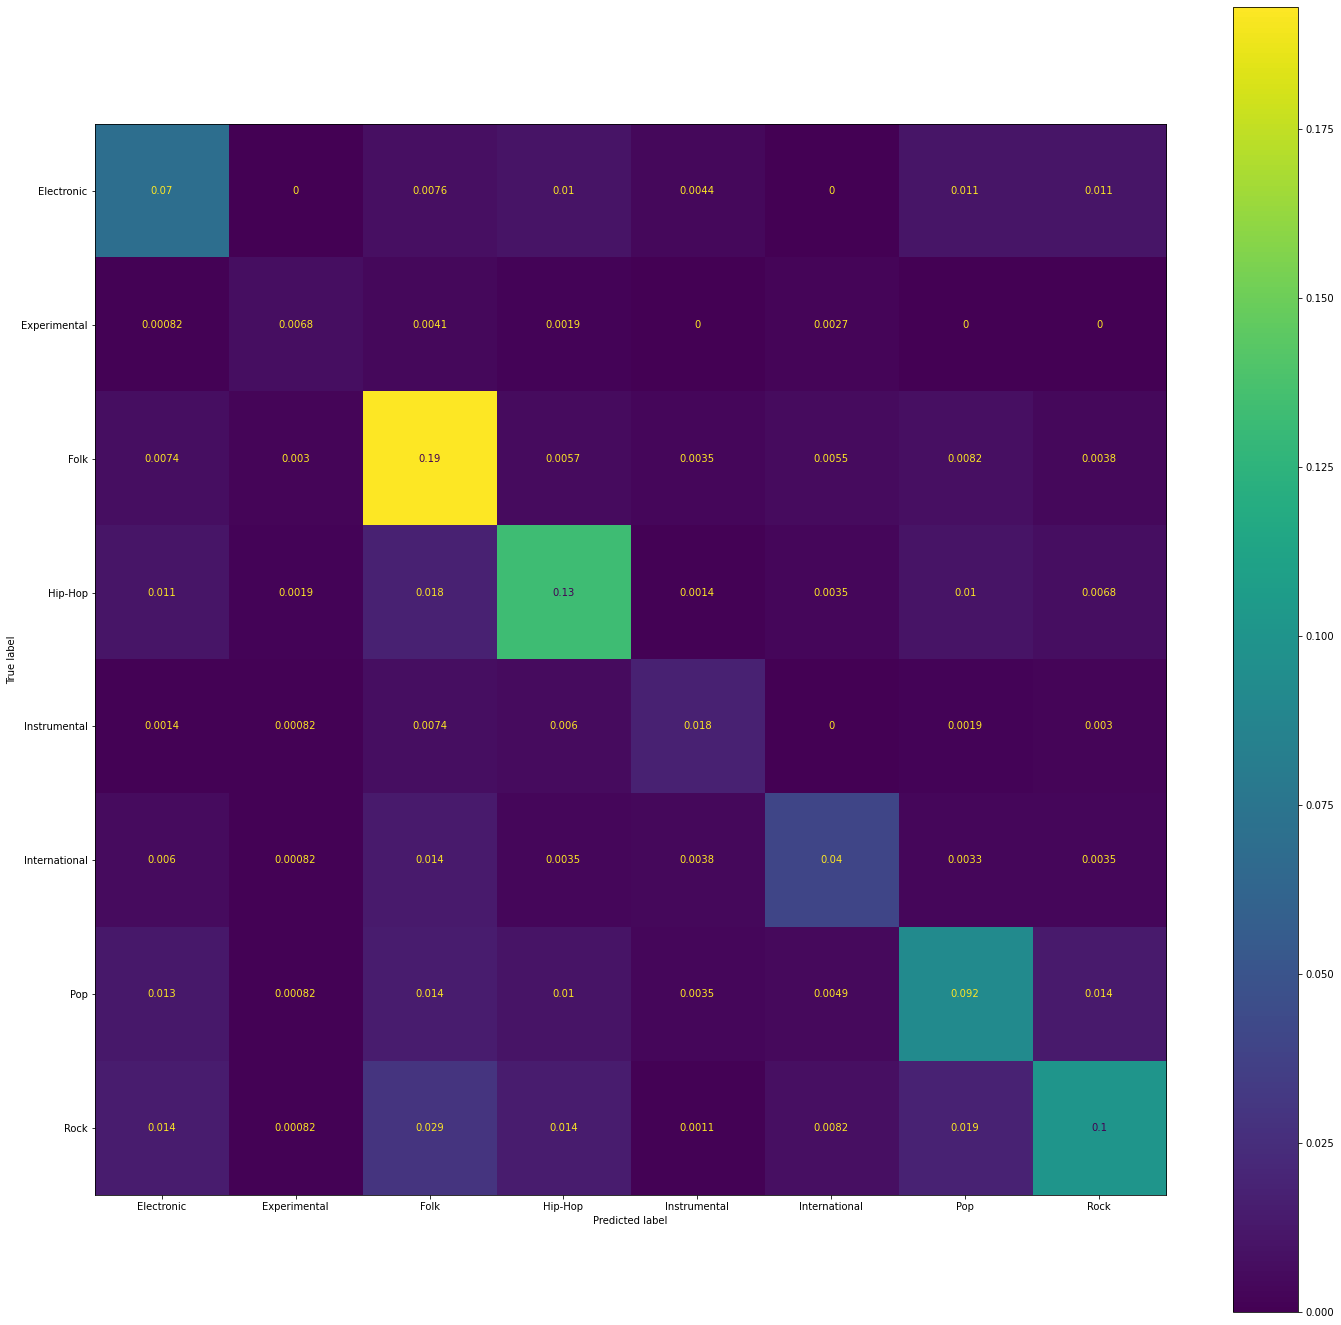

In [19]:
cm = confusion_matrix(y_test, y_pred_knn, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Support Vector Machine Classifier

In [20]:
%%time
SVMmodel = SVC()
SVMmodel.fit(x_train, y_train)
y_pred_svm =  SVMmodel.predict(x_test)

print_report(y_test, y_pred_svm)

Accuracy Score is:	 0.275
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       418
           1       0.00      0.00      0.00        60
           2       0.31      0.61      0.41       844
           3       0.00      0.00      0.00       681
           4       0.00      0.00      0.00       140
           5       0.00      0.00      0.00       277
           6       0.21      0.36      0.27       561
           7       0.28      0.42      0.33       688

    accuracy                           0.28      3669
   macro avg       0.10      0.17      0.13      3669
weighted avg       0.16      0.28      0.20      3669

[[  0   0 169   0   0   0 130 119]
 [  0   0  26   0   0   0  16  18]
 [  0   0 518   0   0   0 150 176]
 [  0   0 388   0   0   0 104 189]
 [  0   0  69   0   0   0  57  14]
 [  0   0 127   0   0   0  73  77]
 [  0   0 199   0   0   0 201 161]
 [  0   0 190   0   0   0 208 290]]
CPU times: user 15.3 s, sys: 7.77 s, total

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

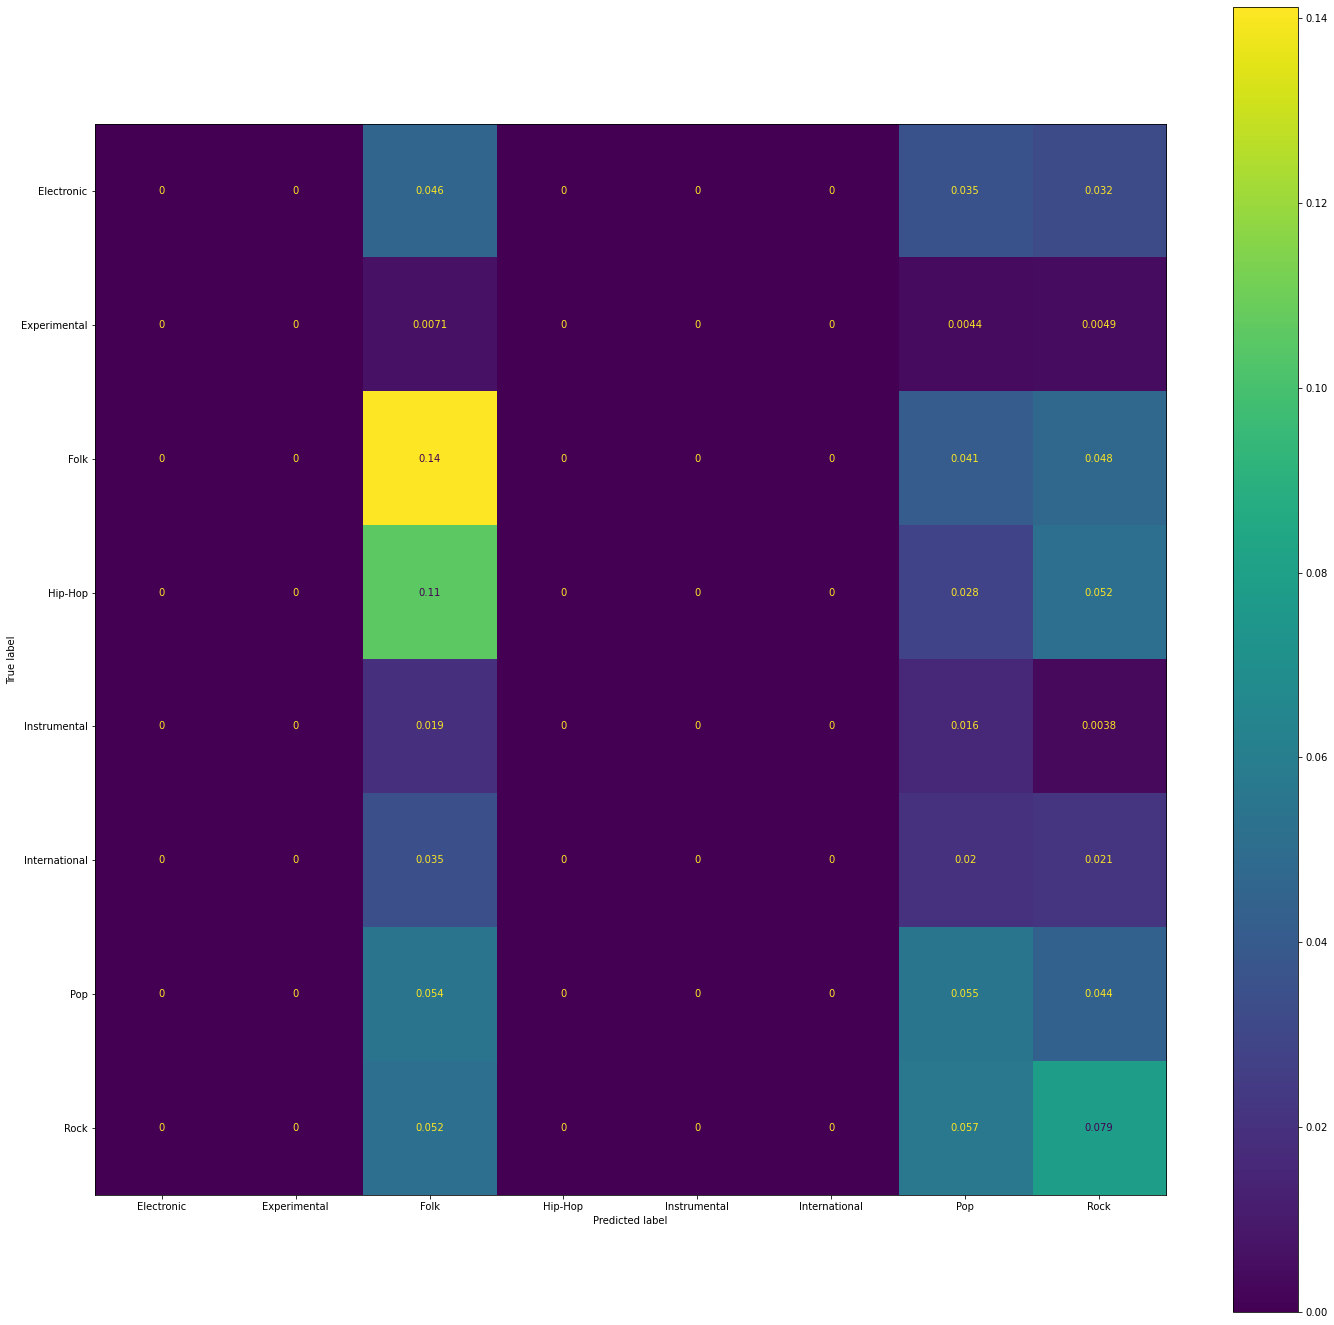

In [21]:
cm = confusion_matrix(y_test, y_pred_svm, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Random Forest Classifier

In [22]:
%%time

RFmodel = RandomForestClassifier()
RFmodel.fit(x_train, y_train)

y_pred_rf =  RFmodel.predict(x_test)
print_report(y_test, y_pred_rf)

Accuracy Score is:	 0.997
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       418
           1       1.00      1.00      1.00        60
           2       0.99      1.00      1.00       844
           3       1.00      1.00      1.00       681
           4       1.00      1.00      1.00       140
           5       1.00      1.00      1.00       277
           6       1.00      0.99      1.00       561
           7       0.99      1.00      1.00       688

    accuracy                           1.00      3669
   macro avg       1.00      1.00      1.00      3669
weighted avg       1.00      1.00      1.00      3669

[[413   0   0   0   0   0   0   5]
 [  0  60   0   0   0   0   0   0]
 [  0   0 844   0   0   0   0   0]
 [  0   0   0 681   0   0   0   0]
 [  0   0   0   0 140   0   0   0]
 [  0   0   0   0   0 277   0   0]
 [  0   0   5   0   0   0 556   0]
 [  0   0   0   0   0   0   0 688]]
CPU times: user 1.51 s, sys: 91.6 ms, tota

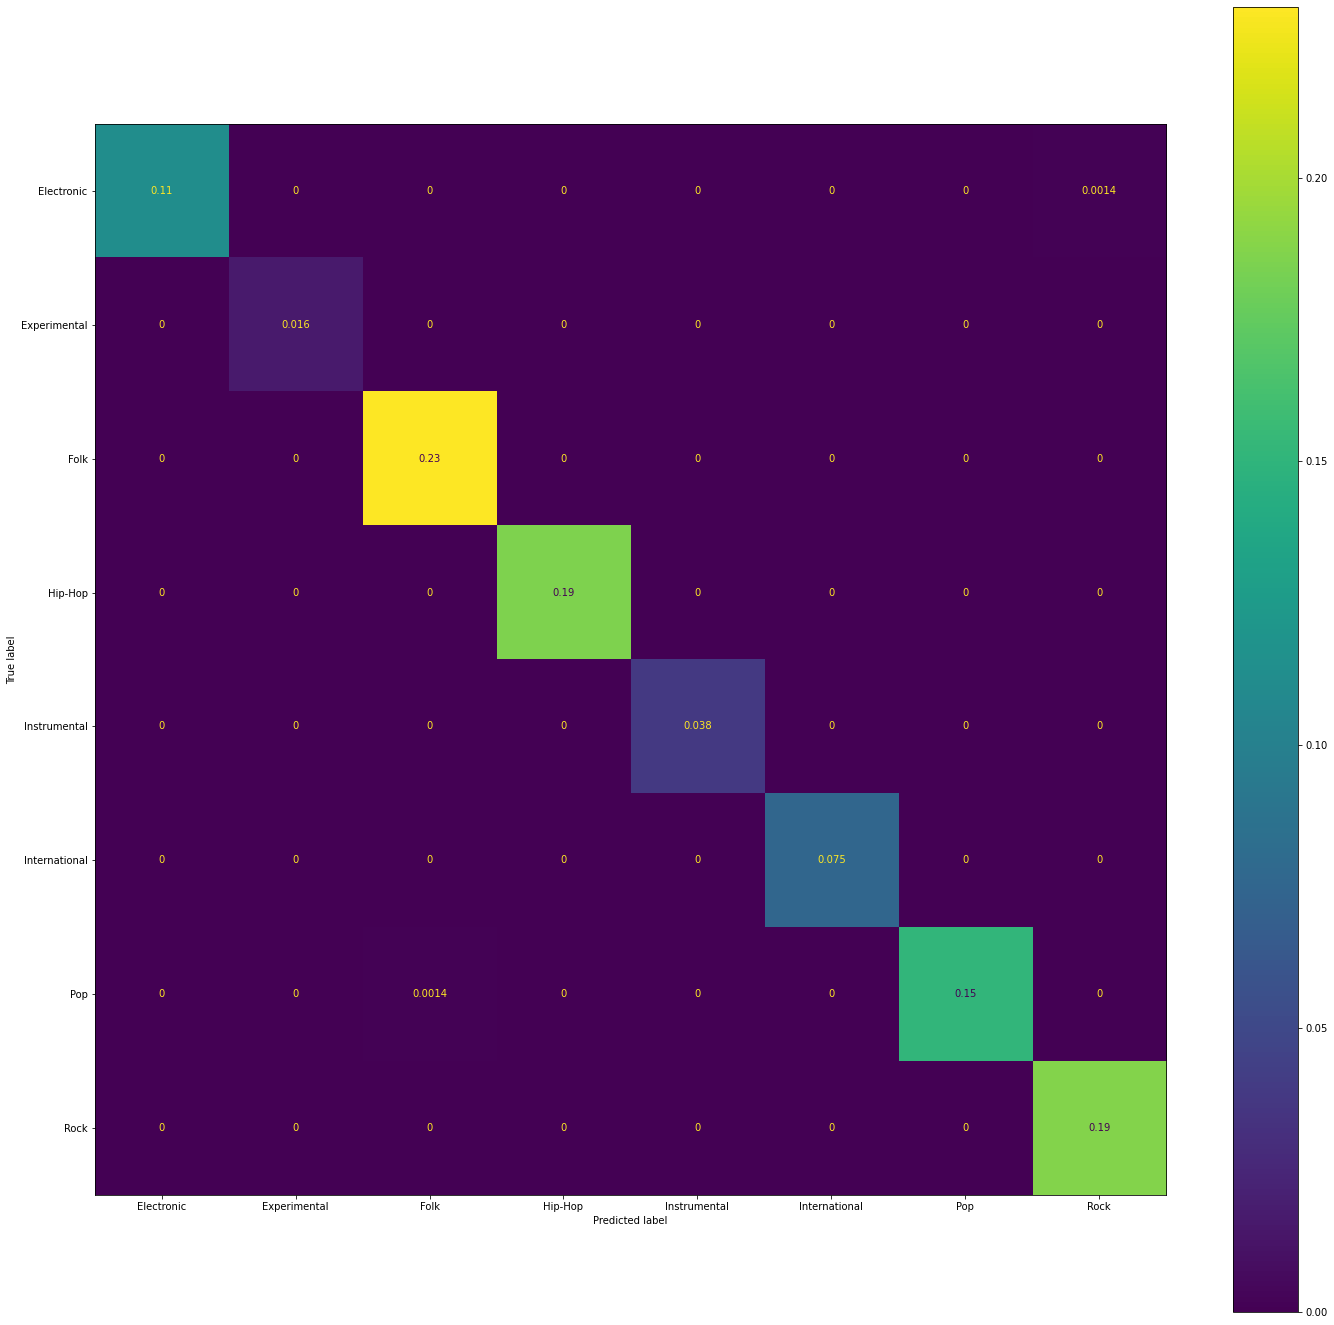

In [23]:
cm = confusion_matrix(y_test, y_pred_rf, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Gradient Boosted Classifier

In [24]:
%%time

XGBmodel = XGBClassifier()
XGBmodel.fit(x_train, y_train)

y_pred_xgb =  XGBmodel.predict(x_test)
print_report(y_test, y_pred_xgb)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score is:	 0.997
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       418
           1       1.00      1.00      1.00        60
           2       0.99      1.00      1.00       844
           3       1.00      1.00      1.00       681
           4       1.00      1.00      1.00       140
           5       1.00      1.00      1.00       277
           6       1.00      0.99      1.00       561
           7       0.99      1.00      1.00       688

    accuracy                           1.00      3669
   macro avg       1.00      1.00      1.00      3669
weighted avg       1.00      1.00      1.00      3669

[[413   0   0   0   0   0   0   5]
 [  0  60   0   0   0   0   0   0]


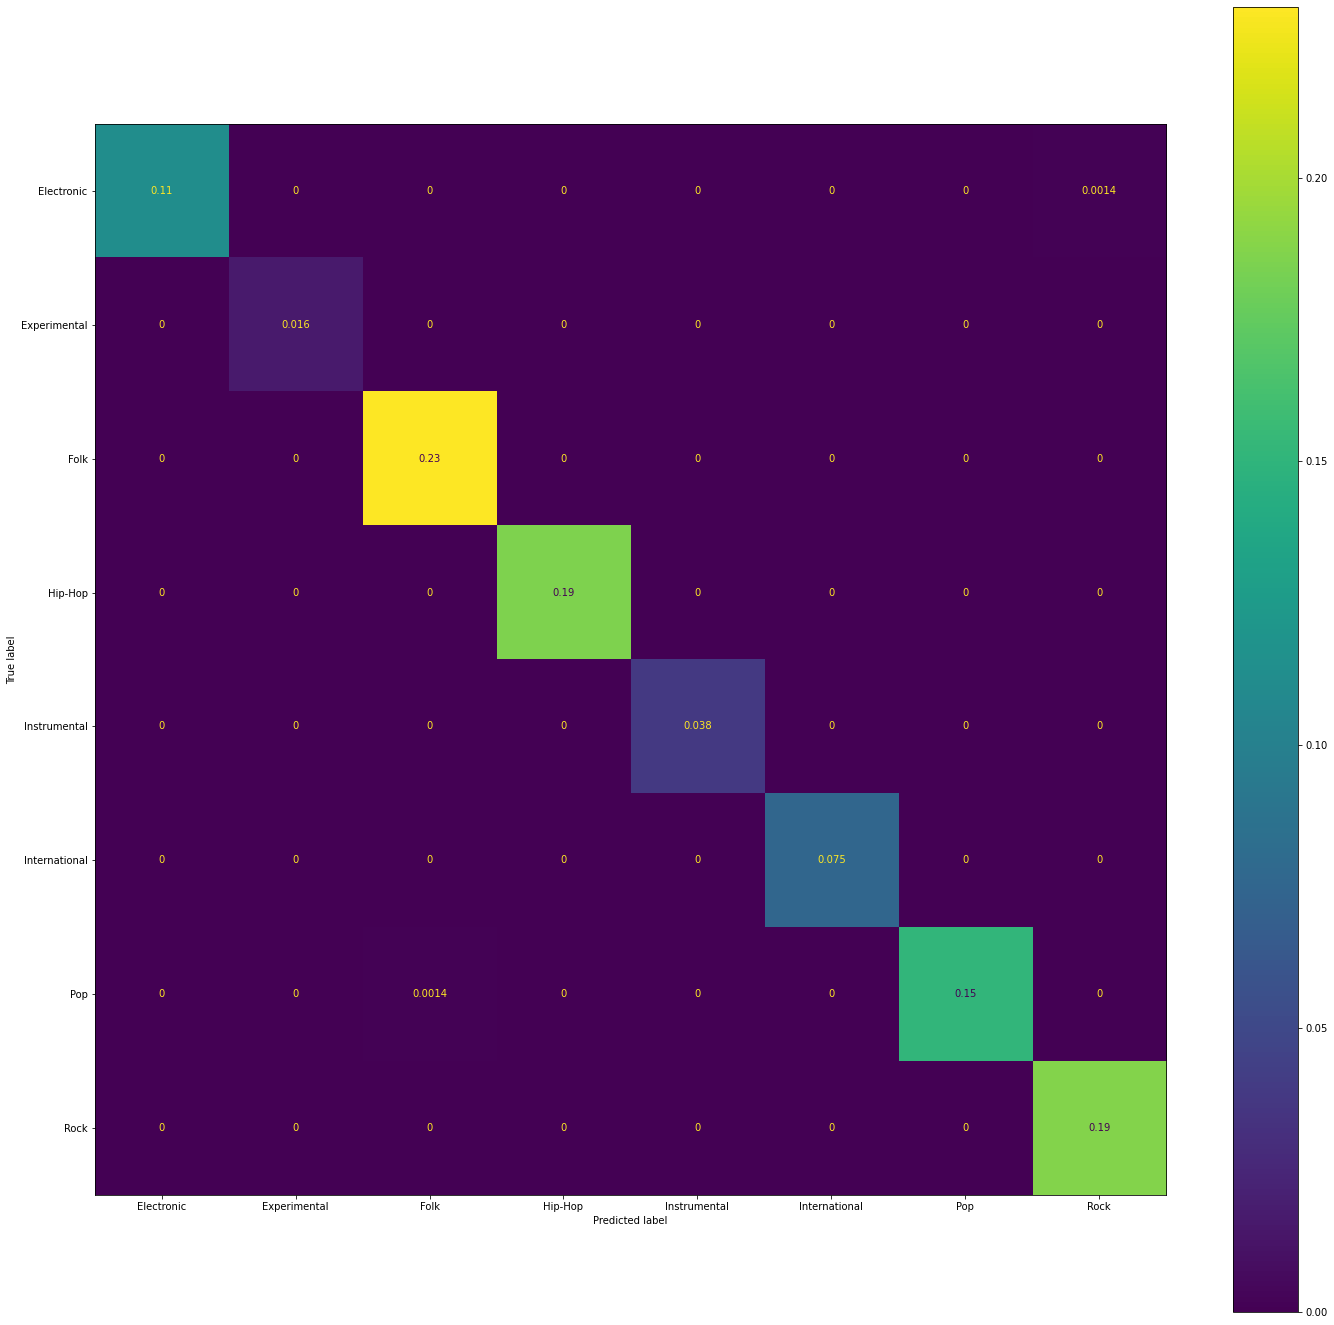

In [25]:
cm = confusion_matrix(y_test, y_pred_xgb, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

## Deep Learning Models

### Fully Connected Neural Network / MLP

In [26]:
mlp = build_multimodal_mlp(mlp_input_shape)

# output layer
mlp.add(keras.layers.Dense(len(genres), activation='softmax'))

OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)
mlp.compile(loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=OPTIMIZER)

mlp.summary()

MODEL_SAVE_PATH = MODEL_PATH + "/fma_mlp/"
saveBest, es, lr = setup_callbacks(mlp, MODEL_SAVE_PATH)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1

2022-05-02 21:16:58.752468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 21:16:58.752502: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 21:16:58.752524: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (earhart): /proc/driver/nvidia/version does not exist
2022-05-02 21:16:58.753085: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
178/188 [===========================>..] - ETA: 0s - loss: 9.0329 - accuracy: 0.1598
Epoch 1: val_loss improved from inf to 2.87078, saving model to /storage/graham/music/models//fma_mlp/


2022-05-02 21:16:59.995766: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


188/188 [==============================] - 1s 6ms/step - loss: 8.8879 - accuracy: 0.1603 - val_loss: 2.8708 - val_accuracy: 0.1889 - lr: 1.0000e-04
Epoch 2/30
180/188 [===========================>..] - ETA: 0s - loss: 5.3263 - accuracy: 0.1444
Epoch 2: val_loss improved from 2.87078 to 2.15804, saving model to /storage/graham/music/models//fma_mlp/
188/188 [==============================] - 1s 4ms/step - loss: 5.2912 - accuracy: 0.1449 - val_loss: 2.1580 - val_accuracy: 0.0997 - lr: 1.0000e-04
Epoch 3/30
169/188 [=========================>....] - ETA: 0s - loss: 3.8396 - accuracy: 0.1457
Epoch 3: val_loss improved from 2.15804 to 2.12986, saving model to /storage/graham/music/models//fma_mlp/
188/188 [==============================] - 1s 5ms/step - loss: 3.7917 - accuracy: 0.1452 - val_loss: 2.1299 - val_accuracy: 0.1507 - lr: 1.0000e-04
Epoch 4/30
172/188 [==========================>...] - ETA: 0s - loss: 3.2123 - accuracy: 0.1486
Epoch 4: val_loss improved from 2.12986 to 2.12074, sa

Epoch 25/30
180/188 [===========================>..] - ETA: 0s - loss: 2.0366 - accuracy: 0.2220
Epoch 25: val_loss improved from 2.01183 to 2.00847, saving model to /storage/graham/music/models//fma_mlp/
188/188 [==============================] - 1s 4ms/step - loss: 2.0380 - accuracy: 0.2217 - val_loss: 2.0085 - val_accuracy: 0.2157 - lr: 1.0000e-04
Epoch 26/30
183/188 [============================>.] - ETA: 0s - loss: 2.0247 - accuracy: 0.2208
Epoch 26: val_loss improved from 2.00847 to 2.00517, saving model to /storage/graham/music/models//fma_mlp/
188/188 [==============================] - 1s 4ms/step - loss: 2.0254 - accuracy: 0.2212 - val_loss: 2.0052 - val_accuracy: 0.2157 - lr: 1.0000e-04
Epoch 27/30
181/188 [===========================>..] - ETA: 0s - loss: 2.0256 - accuracy: 0.2222
Epoch 27: val_loss improved from 2.00517 to 2.00199, saving model to /storage/graham/music/models//fma_mlp/
188/188 [==============================] - 1s 4ms/step - loss: 2.0241 - accuracy: 0.2220 

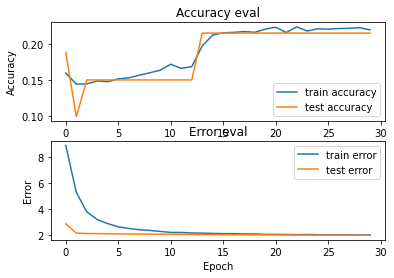

115/115 - 0s - loss: 1.9874 - accuracy: 0.2300 - 78ms/epoch - 677us/step

Test accuracy: 0.2300354391336441


In [27]:
# train model
history = mlp.fit(x_train, y_train, 
                  validation_data=(x_val, y_val), 
                  batch_size=32, 
                  epochs=30,
                  callbacks=[saveBest, es, lr]
                 )

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = mlp.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

### Convolutional Neural Network

In [28]:
cnn = build_multimodal_cnn(cnn_input_shape)

# output layer
cnn.add(keras.layers.Dense(len(genres), activation='softmax'))

cnn.compile(loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=OPTIMIZER)

cnn.summary()

MODEL_SAVE_PATH = MODEL_PATH + "/fma_cnn/"
saveBest, es, lr = setup_callbacks(cnn, MODEL_SAVE_PATH)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 129, 6, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 2, 32)        0         
 2D)                                                             
                                                      

Epoch 1/30
186/188 [============================>.] - ETA: 0s - loss: 1.8985 - accuracy: 0.3511
Epoch 1: val_loss improved from inf to 1.67003, saving model to /storage/graham/music/models//fma_cnn/
188/188 [==============================] - 5s 25ms/step - loss: 1.8998 - accuracy: 0.3516 - val_loss: 1.6700 - val_accuracy: 0.4120 - lr: 1.0000e-04
Epoch 2/30
185/188 [============================>.] - ETA: 0s - loss: 1.5801 - accuracy: 0.4412
Epoch 2: val_loss improved from 1.67003 to 1.45677, saving model to /storage/graham/music/models//fma_cnn/
188/188 [==============================] - 6s 30ms/step - loss: 1.5782 - accuracy: 0.4416 - val_loss: 1.4568 - val_accuracy: 0.4883 - lr: 1.0000e-04
Epoch 3/30
187/188 [============================>.] - ETA: 0s - loss: 1.4879 - accuracy: 0.4746
Epoch 3: val_loss improved from 1.45677 to 1.39243, saving model to /storage/graham/music/models//fma_cnn/
188/188 [==============================] - 5s 25ms/step - loss: 1.4876 - accuracy: 0.4746 - val_l

Epoch 27/30
185/188 [============================>.] - ETA: 0s - loss: 0.9083 - accuracy: 0.6748
Epoch 27: val_loss did not improve from 1.16406
188/188 [==============================] - 3s 18ms/step - loss: 0.9098 - accuracy: 0.6741 - val_loss: 1.1940 - val_accuracy: 0.5837 - lr: 1.0000e-04
Epoch 28/30
188/188 [==============================] - ETA: 0s - loss: 0.8955 - accuracy: 0.6755
Epoch 28: val_loss improved from 1.16406 to 1.15928, saving model to /storage/graham/music/models//fma_cnn/
188/188 [==============================] - 4s 23ms/step - loss: 0.8955 - accuracy: 0.6755 - val_loss: 1.1593 - val_accuracy: 0.5946 - lr: 1.0000e-04
Epoch 29/30
187/188 [============================>.] - ETA: 0s - loss: 0.8901 - accuracy: 0.6870
Epoch 29: val_loss did not improve from 1.15928
188/188 [==============================] - 3s 19ms/step - loss: 0.8905 - accuracy: 0.6866 - val_loss: 1.2057 - val_accuracy: 0.5829 - lr: 1.0000e-04
Epoch 30/30
186/188 [============================>.] - ETA

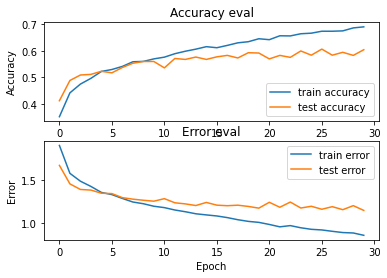

115/115 - 0s - loss: 1.1527 - accuracy: 0.6026 - 416ms/epoch - 4ms/step

Test accuracy: 0.6026164889335632


In [29]:
# train model
history = cnn.fit(mfcc_train_cnn, y_train, 
                  validation_data=(mfcc_val_cnn, y_val), 
                  batch_size=32, 
                  epochs=30,
                  callbacks=[saveBest, es, lr]
                 )

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = cnn.evaluate(mfcc_test_cnn, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

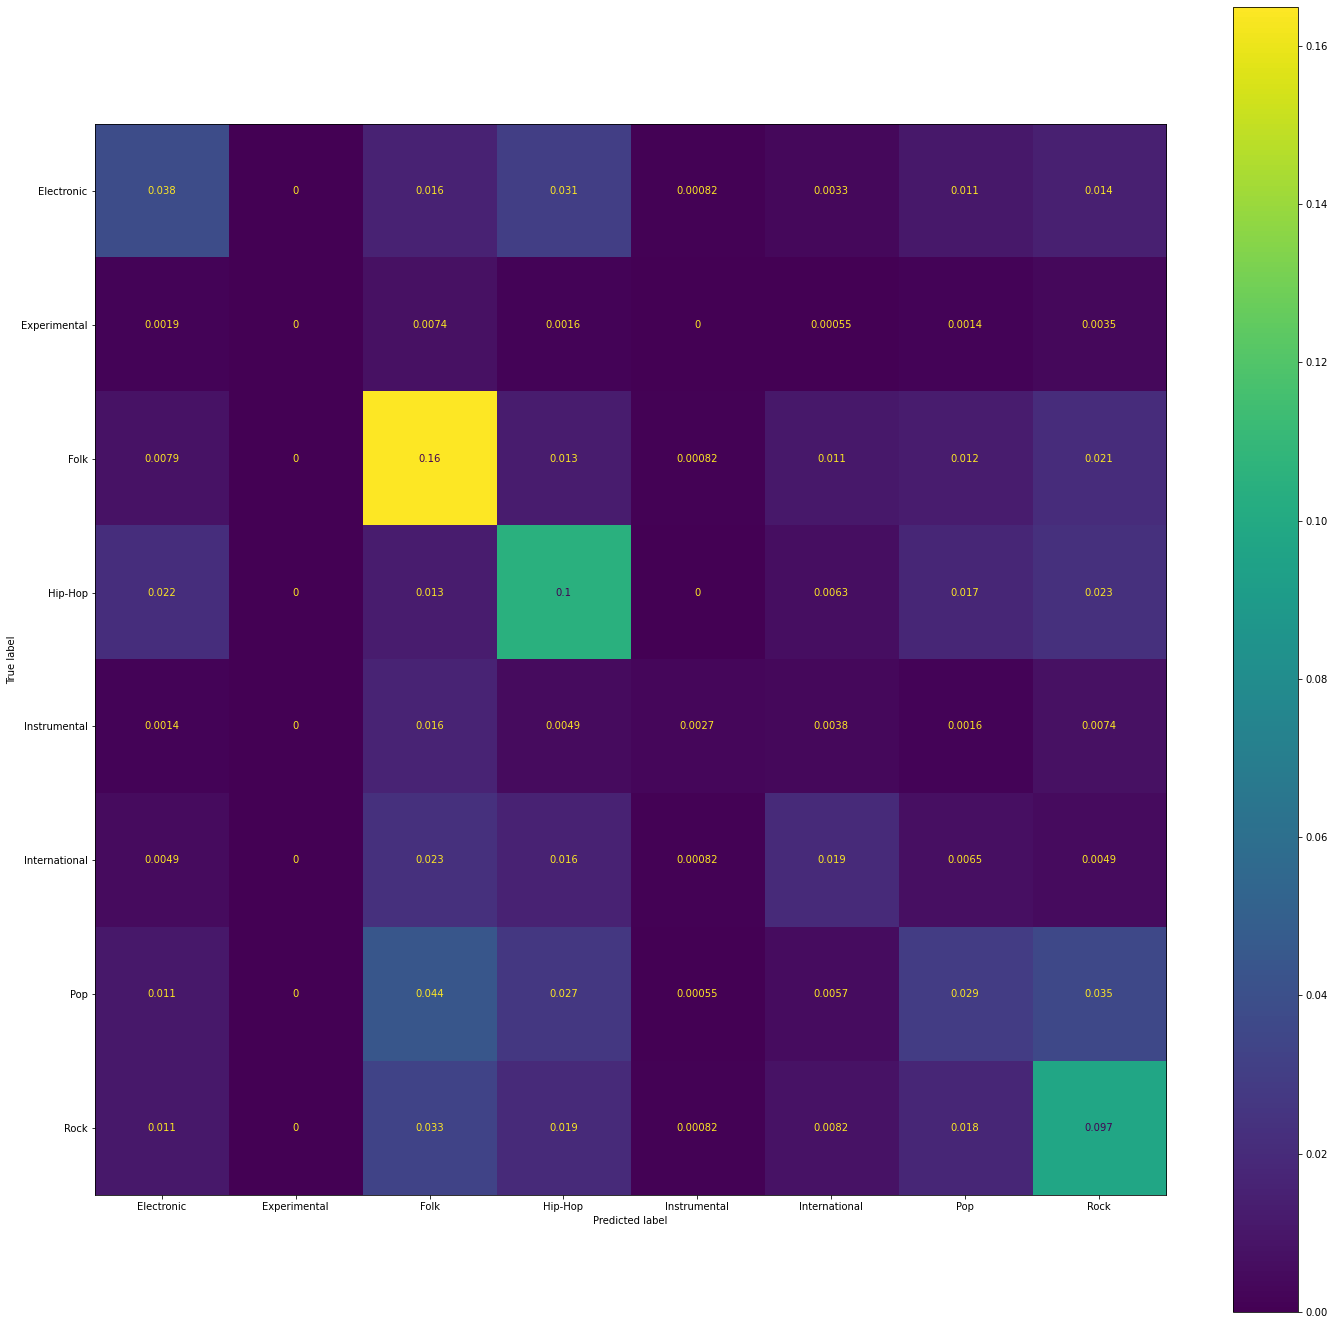

In [39]:
y_prob = cnn.predict(mfcc_test_cnn)
y_pred_cnn = y_prob.argmax(axis=-1)

cm = confusion_matrix(y_test, y_pred_cnn, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)